In [1]:
import json as js
import org_research as org
import glob
import sys

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction import text 
from sklearn.cluster import KMeans, MiniBatchKMeans

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

In [5]:
import numpy as np
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

In [6]:
import os
from copy import deepcopy
import time
import datetime

In [7]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/g/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
ENGLISH = False

In [9]:
additional_stop_words = [''] ##USE THIS FOR STOP WORDS
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

In [10]:
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in tokenizer.tokenize(doc)]

In [11]:
directory = './data/test/*'

## LOAD TWEET OBJECTS

In [12]:
tweet_objects = []
dirs = glob.glob(directory)
cterr = 0
ctln = 0
for dr in dirs:
    files = glob.glob(dr+'/*')
    for f in files:
            fin = open(f,'r')
            for line in fin:
                ctln += 1
                try:
                    dat = js.loads(line)
                    tweet_objects.append(dat)
                except:
                    cterr += 1
                    continue
            fin.close()

In [13]:
print(cterr)
print(ctln)
print(len(tweet_objects))

227371
454742
227371


## EXTRACT DATA AND EXPORT TO TEMPORARY FILE

In [14]:
fout = open('tmp.dat','w')
ctke = 0
for ln in tweet_objects:
    try:
        entities = ln['entities']
    #    hashtags = entities['hashtags']
        user_mentions = entities['user_mentions']
    except KeyError:
        continue
    #for hashtag in hashtags:
    try:
    #        hashtag = hashtag['text']
        date = ln['created_at']
        date = date.split()
        date = str(date[1])+'-'+str(date[2])+'18_'+str(date[3])
        favorite_count = ln['favorite_count']
        user = ln['user']
        if ENGLISH == True:
            lang = user['lang']
            if lang == 'en':
                continue
        followers = user['followers_count']
        username = user['screen_name']
        location = user['location']
        if ln['truncated'] == True:
            xtweet = ln['extended_tweet']
            txt = xtweet['full_text']
        else:
            txt = ln['text'].replace('\n','')
        fout.write(date + '\t' + str(favorite_count)+','+str(followers)+',"'+str(username)+'","'+str(location)+'","'+str(txt)+'"\n')
    except UnicodeEncodeError:#.encode('utf-8')
        continue
    except KeyError:
        ctke += 1
fout.close()

## OPEN TMP FILE AS DATAFRAME

In [15]:
df = pd.read_csv('tmp.dat',error_bad_lines=False,header=None,names=\
                 ['date','followers','username','location','tweet'],\
                 delimiter=',',index_col=False)#,encoding='utf-8'
print(df.shape[0])
df.drop_duplicates(inplace=True)
print("Dropping duplicates...")
print(df.shape[0])

228197
Dropping duplicates...
151747


In [16]:
#if rm_duplicates == False:
#    df['rt'] = df['tweet'].str.split(':', expand=True).ix[:,0]
#    df.drop_duplicates(subset=['rt'], keep='first',inplace=True)
#    df.rt.head()
#    df.shape[0]

### Potential Cashtags

In [17]:
ct = 0
for i in range (df.shape[0]):
    try:
        if " $" in df.tweet.iloc[i]:
            #print(df.tweet.iloc[i])
            ct += 1
    except TypeError:
        continue
print(ct)

1173


## REMOVING TWEETS FROM DATASET

In [18]:
'''
*** Tweets often use popular hashtags with unrelated topics.
*** Certain words can be used in order to filter such tweets.
*** Enter these words below in the bad_terms list.
'''
bad_terms = [] #foxnews','foxandfriends']
for i in range(len(bad_terms)):
    df.bad = df['tweet'].str.lower().str.contains(bad_terms[i].lower())
    df = df[df.bad == False]

In [19]:
print(df.shape[0])

151747


## Remove Retweets

In [35]:
rm_duplicates = True
if rm_duplicates == True:
    df['rt'] = df['tweet'].str.split(':', expand=True).iloc[:,0]
    df.drop_duplicates(subset=['rt'], keep='first',inplace=True)
    df.rt.head()
    print(df.shape[0])

119545


### Clean nans etc.

In [36]:
df = df.dropna()

In [37]:
print(df.shape[0])

119541


## CLUSTERING USING K-MEANS

In [21]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [22]:
n_features = 300
n_topics = 12
n_top_words = 10
n_top_tweets = 15
ngram = 3

In [23]:
additional_stop_words = ['t','http','s','o','e','u','m','y','i','2',\
                        'ha','dm','ve','let','don','need','just',\
                         'did','d','oh','la','el','v','realdonaldtrump'] ##USE THIS FOR STOP WORDS
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5,max_features=n_features,stop_words=stop_words,\
                                  ngram_range=(1,ngram),tokenizer=LemmaTokenizer())
tfidf = tfidf_vectorizer.fit_transform(df.tweet)

/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [25]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [26]:
km = KMeans(n_clusters=n_topics, init='k-means++', max_iter=100, n_init=1, verbose=True)
km.fit(tfidf)

Initialization complete
Iteration  0, inertia 106749.744
Iteration  1, inertia 103351.077
Iteration  2, inertia 101962.758
Iteration  3, inertia 101220.256
Iteration  4, inertia 101051.371
Iteration  5, inertia 100951.926
Iteration  6, inertia 100870.986
Iteration  7, inertia 100844.719
Iteration  8, inertia 100825.471
Iteration  9, inertia 100820.231
Iteration 10, inertia 100816.420
Iteration 11, inertia 100816.328
Iteration 12, inertia 100816.313
Iteration 13, inertia 100816.311
Converged at iteration 13: center shift 0.000000e+00 within tolerance 2.805167e-07


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=12, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=True)

In [27]:
kmeans_embedding = km.transform(tfidf)
kmeans_embedding = -(kmeans_embedding - kmeans_embedding.mean(axis=0))/kmeans_embedding.std(axis=0)

In [28]:
#top_idx = np.argsort(kmeans_embedding,axis=0)[-10:]
preds = km.predict(tfidf)
count = 0
for i in range(n_topics):#, idxs in enumerate(top_idx.T): 
    print("Topic {}:".format(count))
    topic = km.cluster_centers_[i]
    print(" ".join([str(tfidf_feature_names[i])+'\n' for i in topic.argsort()[:-n_top_words - 1:-1]]))
    ct = 0
    top_tweets = []
    t = 0
    for t in range(len(preds)):
    #while ct != n_top_tweets & t<:
        if preds[t] == i:
            top_tweet = df.iloc[t]['tweet']
            if top_tweet not in top_tweets:
                print(top_tweet)
                top_tweets.append(top_tweet)
                ct += 1
        if ct == n_top_tweets:
            break
        t += 1
    count += 1
    print('\n\n')

Topic 0:
que
 en
 por
 para
 los
 lo
 te
 se
 youtube
 tu

@Gabrielarbizu @YouTube @Gabrielarbizu Cada dia les admiro y quiero más. A ambos y en lo individual.
@maesogomes @NetflixBrasil Melhor que isso só meus beijos suauhsuahs
@Wearesuprime @SaveWhitesInZA @ABC Soos wat ek hulle ken ń vakansiedag en nog ń plek waar duiwe lief is om te kak! 👌😂
@NBCNews dime lo que te falto y ofendo es como resi  centro colé y mas para los que no los si de todo
@oGustavoLima @Meninooo_ @BurgerKingBR Ah pronto... Será que os bonito tbm queria os 50 reais? 😂 https://t.co/p2ewQcjXke
@BWWings @CoorsLight What's the deal with the domestic feature"...you have sales on those er sun en?"
@CocaColaMx @miseleccionmx En realidad creen que es el mejor equipo? O solamente son los menos pendejos en éste momento? Aclaren por favor
@MEP_OFFICIAL Bonjour. Pouvons-nous vous aider ? Quel souci rencontrez-vous avec Google Chrome ? N'hésitez pas à revenir vers nous avec plus de détails pour que nous puissions vous assister

In [29]:
org.CSEARCH[0]

'abmd'

## T-SNE Visualization

In [232]:
tsne = TSNE(random_state=1,metric='cosine',init='pca',perplexity=100.) #TODO: TRY DIFFERENT DISTANCE METRICS!!
tsne_embedding = tsne.fit_transform(kmeans_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = kmeans_embedding.argmax(axis=1) 

In [233]:
topics = [i+1 for i in range(n_topics)]
topics = ['tech/fintech','deep learning/AI','machine learning/AI','data science/big data','future/tech/AI','machine learning','AI']

In [234]:
cmap = matplotlib.cm.get_cmap('nipy_spectral_r')

In [235]:
colors = []
for i in range(n_topics):
    val = (float(i))/(n_topics-1)
    colors.append(cmap(val))

In [236]:
legend_list = []
for i in range((n_topics)):   
    color = colors[i]
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

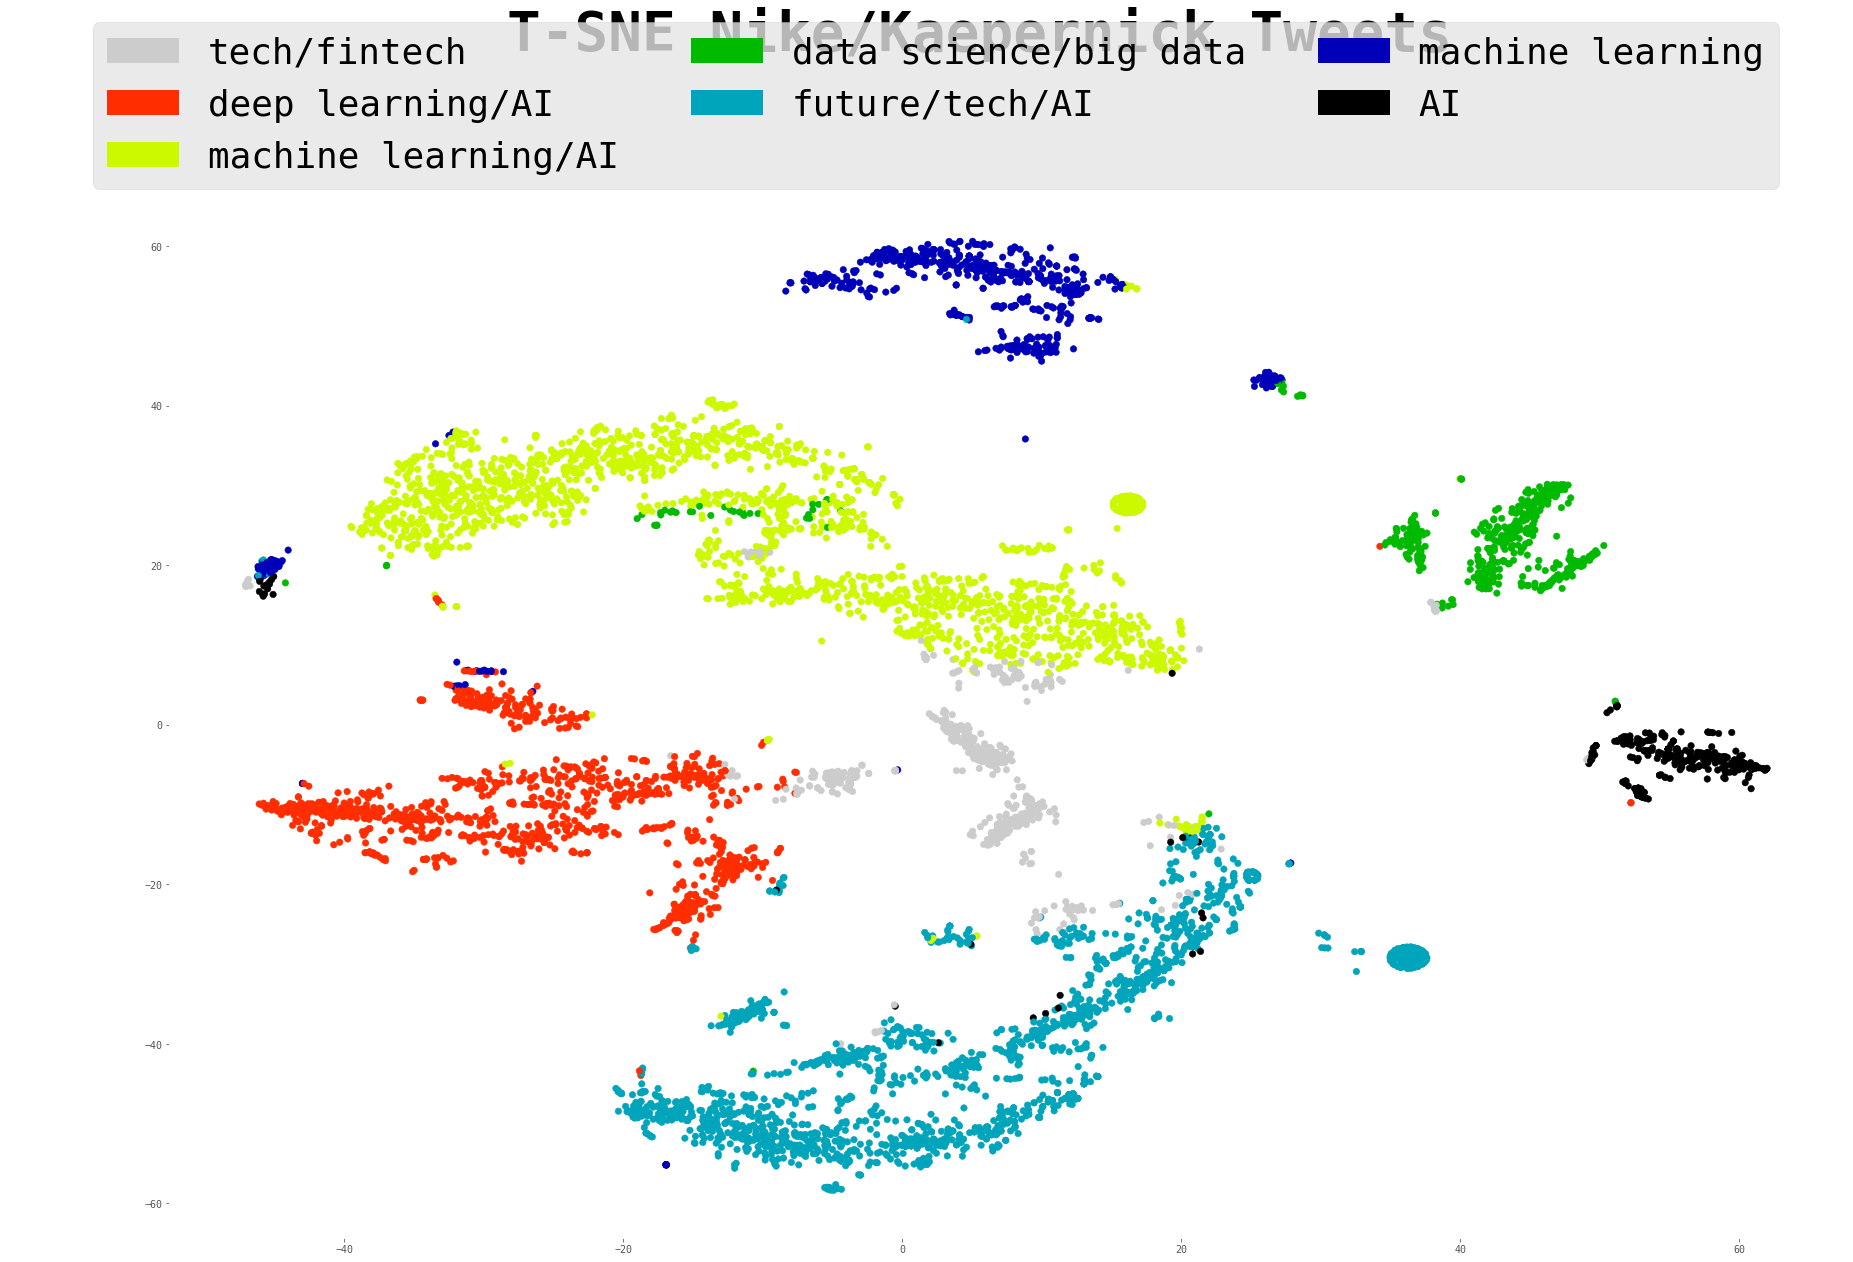

In [237]:
matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')
fig, axs = plt.subplots(1,1, figsize=(30, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)
axs.set_facecolor('white')
count = 0
legend = []
data = tsne_embedding
scatter = axs.scatter(data=data,x='x',y='y',s=42,c=data['hue'],cmap='nipy_spectral_r')
plt.suptitle("T-SNE Nike/Kaepernick Tweets",**{'fontsize':'56','weight':'bold'},ha='center')
#plt.figtext(.51,0.95,'LDA topic clusters reduced to 2-d with t-SNE  ', **{'fontsize':'46','weight':'light'}, ha='center')
fig.legend(legend_list,topics,loc=(0.05,0.85),ncol=3,fontsize=36)
plt.subplots_adjust(top=0.85)
plt.show()
#plt.savefig('K-means_T-SNE_visualization.png') #enter filename here to save vizualization to file

([<matplotlib.axis.XTick at 0x1316f20f0>,
 <a list of 7 Text xticklabel objects>)

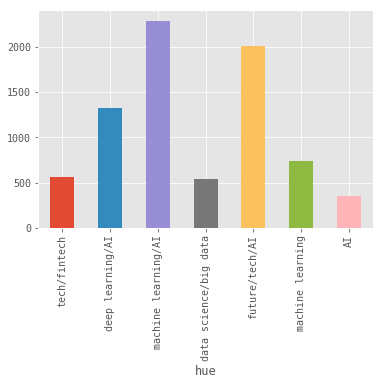

In [238]:
freq = tsne_embedding.groupby('hue').count()
fig, ax = plt.subplots()
indices = [i for i in range(n_topics)]
freq['x'].plot(ax=ax, kind='bar')
plt.xticks(indices, topics)
#plt.savefig('K-means_cluster_size_comparison.png',transparent=True)

In [4]:
df = pd.read_csv('stop_words.csv', header=None)

In [8]:
data = list(df.iloc[0])

In [9]:
ndata = []
for d in data:
    ndata.append(d.strip(' '))

In [15]:
for d in ndata:
    print("'"+d+"',", end="")

'no','noone','nobody','nowhere','nothing','nor','not','none','non','a','able','about','above','according','accordingly','across','actually','after','afterwards','again','against','all','allow','allows','almost','alone','along','already','also','although','always','am','among','amongst','an','and','another','any','anybody','anyhow','anyone','anything','anyway','anyways','anywhere','apart','appear','appreciate','appropriate','are','aren','around','as','aside','ask','asking','associated','at','available','away','awfully','b','be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','believe','below','beside','besides','best','better','between','beyond','both','brief','but','by','c','came','can','cannot','cant','cause','causes','certain','certainly','changes','clearly','co','com','come','comes','concerning','consequently','consider','considering','contain','containing','contains','corresponding','could','couldnt','couldn','couldve','course','curren